In [2]:
# Run this first!!!
from IPython.display import display, HTML

from __future__ import division
import matplotlib.pyplot as plt
from scipy.optimize import brentq

import sys
sys.path.append('..')
import util
sys.path.append('../aho_merging')
from size_model import SizeModel
sys.path.append('../common')
import common_probs
from sampler import DepthSampler

# Parameter Finding

## By Eye

Let's first see if we can choose appropriate parameters by eye so that it closely fits the curve of the simulated algorithm. Doing this can help justify the use of this model. Let's consider the case where the size of the alphabet is $a = 4$. If we observe that the average number of active "threads" (failures that do not go to the root state) per level seems to converge to some $\lambda$, we would like our model to also converge to that $\alpha$. To further simplify things also assume that the offspring distribution $F$ only has positive probability on having at most two children. Therefore we essentially have two equations and four unknowns (where $p_0$, $p_1$, and $p_2$ are the probabilities of having zero, one, or two offspring respectively):

$$
\frac{\mu_X}{1 - \mu_Y} = \lambda \implies \mu_X + \lambda \left(p_1 + 2 p_2\right) = \lambda
$$
and
$$
p_0 + p_1 + p_2 = 1
$$

Therefore, there are two free variables that I arbitrarily choose to be $\mu_X$ and $p_0$. I explored different values of this for $\lambda = 5.5$. After trying a few things and doing comparisons, I found that $\mu_X = 1$ and $p_0 = 0.5$ works pretty well.

However, regardless of what values I picked I could never explain the initial spike that happens before things start to level out. Perhaps this could be explained if we expand the offspring distribution to consider more than just two children.

In [5]:
def plot_trends(num_samples, length, gamma, mu_xs, p0s):
    depths = range(1, length + 1)
    alg_trend = get_alg_trend(num_samples, length)[1:]
    plt.plot(depths, alg_trend, label='Algorithm')
    for mu_x in mu_xs:
        for p0 in p0s:
            p1, p2 = calc_params(mu_x, p0, gamma)
            model_trend = get_model_trend(num_samples, length, mu_x, p0, p1, p2)
            plt.plot(depths, model_trend, linestyle='--', label=('Model;Mu_x: %f;p0: %f' % (mu_x, p0)))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Depth')
    plt.ylabel('Average Number of Threads')
    plt.title('Average Number of Threads vs Depth')
    plt.show()

def calc_params(mu_x, p0, gamma):
    x = (gamma - mu_x) / gamma
    p1 = 2 - 2 * p0 - x
    p2 = x - 1 + p0
    return (p1, p2)
    
def get_alg_trend(num_samples, length):
    ds = DepthSampler([0.5 for _ in range(4)], length)
    df = ds.draw_samples(num_samples, ['threads'])
    return df.groupby('depth')['threads'].mean().tolist()
    
def get_model_trend(num_samples, length, mu_x, p0, p1, p2):
    model = SizeModel(mu_x, [p0, p1, p2])
    return model.do_sims(length, num_samples)

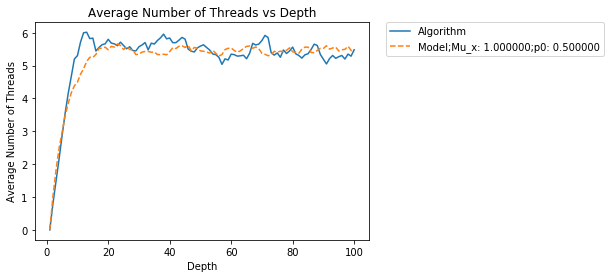

In [6]:
# Constants
NUM_SAMPLES = 1000
LENGTH = 100
GAMMA = 5.5
MU_XS = [1]
P0S = [0.5]

plot_trends(NUM_SAMPLES, LENGTH, GAMMA, MU_XS, P0S)